# Premier League 15 Years Analysis - Part 2

Welcome to Part 2 of our deep dive into 15 years of Premier League history. We're going to tell the story of how English football's elite have battled for supremacy from 2010 to 2025.

Think of this as looking at the Premier League through three different chapters - each telling its own fascinating story of triumph, decline, and unexpected heroes.

In [33]:
# import the imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load the full csv with 15 years of data
pl_15years = pd.read_csv("../data/premier_league_omega.csv")
pl_15years['date'] = pd.to_datetime(pl_15years['date'], format="mixed")
pl_15years.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6141 entries, 0 to 6140
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   division              6140 non-null   object        
 1   date                  6140 non-null   datetime64[ns]
 2   home_team             6140 non-null   object        
 3   away_team             6140 non-null   object        
 4   full_time_home_goals  6140 non-null   float64       
 5   full_time_away_goals  6140 non-null   float64       
 6   full_time_result      6140 non-null   object        
 7   half_time_home_goals  6140 non-null   float64       
 8   half_time_away_goals  6140 non-null   float64       
 9   half_time_result      6140 non-null   object        
 10  referee               6140 non-null   object        
 11  home_shots            6140 non-null   float64       
 12  away_shots            6140 non-null   float64       
 13  home_shots_on_targ

## League Table Function

Re-establishing our comprehensive league table generation function for consistent analysis across different time periods.

In [57]:
def mega_league_table(df):
    table = pd.DataFrame()

    # Home stats
    home = df.groupby("home_team").agg(
        played_home=("home_team", "count"),
        wins_home=("full_time_result", lambda x: (x=="H").sum()),
        draws_home=("full_time_result", lambda x: (x=="D").sum()),
        losses_home=("full_time_result", lambda x: (x=="A").sum()),
        gf_home=("full_time_home_goals", "sum"),
        ga_home=("full_time_away_goals", "sum"),
        shots_home=("home_shots", "sum"),
        shots_on_target_home=("home_shots_on_target", "sum"),
        yellows_home=("home_yellow_cards", "sum"),
        reds_home=("home_red_cards", "sum")        
    )

    # Away stats
    away = df.groupby("away_team").agg(
        played_away=("away_team", "count"),
        wins_away=("full_time_result", lambda x: (x=="A").sum()),
        draws_away=("full_time_result", lambda x: (x=="D").sum()),
        losses_away=("full_time_result", lambda x: (x=="H").sum()),
        gf_away=("full_time_away_goals", "sum"),
        ga_away=("full_time_home_goals", "sum"),
        shots_away=("away_shots", "sum"),
        shots_on_target_away=("away_shots_on_target", "sum"),
        yellows_away=("away_yellow_cards", "sum"),
        reds_away=("away_red_cards", "sum")        
    )

    # Combine
    table = home.join(away, how="outer")
    table = table.fillna(0)

    table["played"] = table["played_home"] + table["played_away"]
    table["wins"] = table["wins_home"] + table["wins_away"]
    table["draws"] = table["draws_home"] + table["draws_away"]
    table["losses"] = table["losses_home"] + table["losses_away"]
    table["goals_for"] = table["gf_home"] + table["gf_away"]
    table["goals_away"] = table["ga_home"] + table["ga_away"]
    table["goal_difference"] = table["goals_for"] - table["goals_away"]
    table["points"] = table["wins"]*3 + table["draws"]
    table["total_shots"] = table["shots_home"] + table["shots_away"]
    table["total_shots_on_target"] = table["shots_on_target_home"] + table["shots_on_target_away"]
    table["total_yellows"] = table["yellows_home"] + table["yellows_away"]
    table["total_reds"] = table["reds_home"] + table["reds_away"]


    table = table[["played","wins","draws","losses","goals_for","goals_away","goal_difference","total_shots","total_shots_on_target","total_yellows","total_reds","points"]]
    return table.sort_values(by=["points","goal_difference","goals_for"], ascending=[False,False,False])

    # 

omega_table = mega_league_table(pl_15years)

## Table Styling Functions

Utility functions for creating professional, publication-ready league tables with color coding and flexible sorting options.

In [58]:
# make a copy so we don't overwrite
final_table = omega_table.copy()

def sort_league_table(by: str = "points", ascending: bool = False):
    """
    Sort the omega league table by any column.
    """
    if by not in final_table.columns:
        raise ValueError(f"Column '{by}' not in table")
    return final_table.sort_values(by=by, ascending=ascending)

def style_league_table(df, color_by="points", title="Omega Premier League Table"):
    """
    Style the league table with gradient coloring and a custom title.
    """
    styled = (
        df.style
        .background_gradient(subset=[color_by], cmap="RdYlGn", axis=0)
        .format("{:.0f}")
        .set_caption(title)
        .set_table_styles([
            {"selector": "th.row_heading", "props": [("font-size", "14pt"), ("font-weight", "bold"), ("color", "yellow")]},
            {"selector": "caption", "props": [("caption-side", "top"), ("font-size", "16pt"), ("font-weight", "bold")]}
        ])
    )
    return styled


In [61]:
display(style_league_table(sort_league_table(by="points"),
                           color_by="total_reds",
                           title="Omega PL Table (by points)"))

,played,wins,draws,losses,goals_for,goals_away,goal_difference,total_shots,total_shots_on_target,total_yellows,total_reds,points
home_team,,,,,,,,,,,,
Man City,614,409,106,99,1389,556,833,10171,4171,934,37,1333
Liverpool,614,351,143,120,1211,649,562,10058,4071,872,35,1196
Arsenal,614,345,130,139,1161,673,488,8958,3744,970,55,1165
Chelsea,614,334,139,141,1118,656,462,9571,3895,1060,44,1141
Man United,614,335,136,143,1063,670,393,8691,3665,1082,34,1141
Tottenham,614,317,126,171,1080,739,341,9052,3853,1037,35,1077
Everton,614,224,179,211,801,794,7,7661,3110,1035,44,851
Newcastle,538,193,128,217,718,787,-69,6641,2551,913,41,707
West Ham,576,185,146,245,756,890,-134,6917,2590,950,39,701


## The Ultimate 15-Year Table

Here's the big reveal - who's really been the most successful Premier League team over the past decade and a half? Notice how the red cards column is highlighted - it shows which teams play with more... let's say "passion"!

The varying number of games played tells its own story - some teams have been ever-present, others have yo-yoed between divisions.

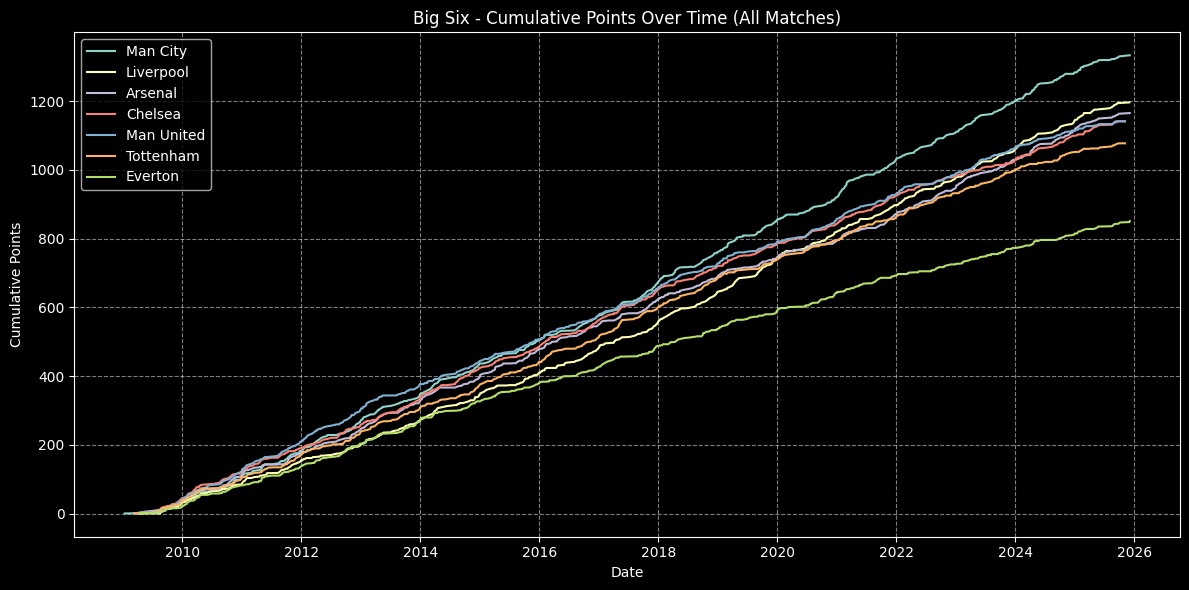

In [52]:
the_614 = ["Man City", "Liverpool", "Arsenal", "Chelsea", "Man United", "Tottenham", "Everton"]

# calculate points per match
pl_15years["home_points"] = np.select(
    [pl_15years["full_time_result"].eq("H"),
     pl_15years["full_time_result"].eq("D")],
    [3,1], default=0
)
pl_15years["away_points"] = np.select(
    [pl_15years["full_time_result"].eq("A"),
     pl_15years["full_time_result"].eq("D")],
    [3,1], default=0
)

# put home/away into same column
home = pl_15years[["date","home_team","home_points"]].rename(
    columns={"home_team":"team","home_points":"points"}
)
away = pl_15years[["date","away_team","away_points"]].rename(
    columns={"away_team":"team","away_points":"points"}
)
matches = pd.concat([home,away], ignore_index=True)

# cumulative points over time
matches = matches.sort_values("date")
matches["cumulative_points"] = matches.groupby("team")["points"].cumsum()

# filter Big Six
big6 = matches[matches["team"].isin(the_614)]

# plot
plt.figure(figsize=(12,6))
for team in the_614:
    team_data = big6[big6["team"]==team]
    plt.plot(team_data["date"], team_data["cumulative_points"], label=team)

plt.title("Big Six - Cumulative Points Over Time (All Matches)")
plt.xlabel("Date")
plt.ylabel("Cumulative Points")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

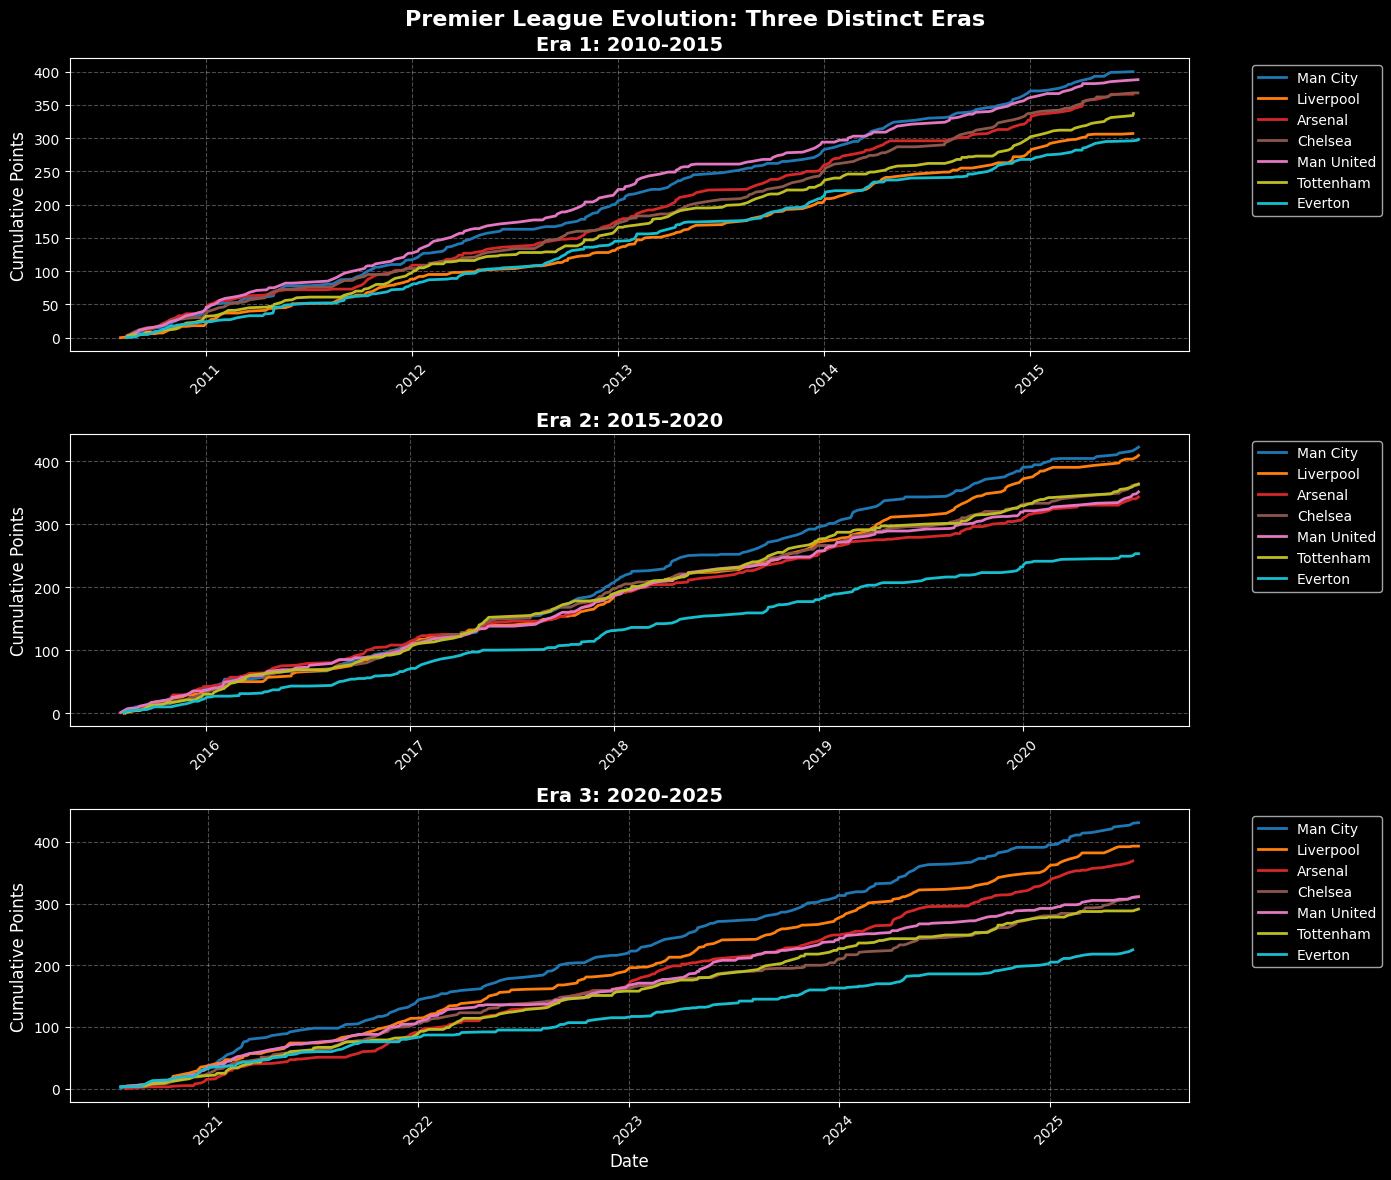

In [53]:
the_614 = ["Man City", "Liverpool", "Arsenal", "Chelsea", "Man United", "Tottenham", "Everton"]

# ensure date is datetime and add season column
pl_15years["date"] = pd.to_datetime(pl_15years["date"], errors="coerce")

# create season column
def get_season_year(date):
    if pd.isna(date):
        return None
    year = date.year
    # Season starts in August
    if date.month >= 8:
        return year
    else:
        return year - 1

pl_15years["season_year"] = pl_15years["date"].apply(get_season_year)

# define eras
def get_era(season_year):
    if pd.isna(season_year):
        return None
    if 2010 <= season_year <= 2014:
        return "Era 1: 2010-2015"
    elif 2015 <= season_year <= 2019:
        return "Era 2: 2015-2020"
    elif 2020 <= season_year <= 2024:
        return "Era 3: 2020-2025"
    else:
        return None

pl_15years["era"] = pl_15years["season_year"].apply(get_era)

# calculate points per match
pl_15years["home_points"] = np.select(
    [pl_15years["full_time_result"].eq("H"),
     pl_15years["full_time_result"].eq("D")],
    [3,1], default=0
)
pl_15years["away_points"] = np.select(
    [pl_15years["full_time_result"].eq("A"),
     pl_15years["full_time_result"].eq("D")],
    [3,1], default=0
)

# create unified match data
home = pl_15years[["date","home_team","home_points","era"]].rename(
    columns={"home_team":"team","home_points":"points"}
)
away = pl_15years[["date","away_team","away_points","era"]].rename(
    columns={"away_team":"team","away_points":"points"}
)
matches = pd.concat([home,away], ignore_index=True)

# remove any matches without era (future seasons)
matches = matches.dropna(subset=["era"])

# sort by date
matches = matches.sort_values("date")

# create the three-era subplot
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle("Premier League Evolution: Three Distinct Eras", fontsize=16, fontweight='bold')

eras = ["Era 1: 2010-2015", "Era 2: 2015-2020", "Era 3: 2020-2025"]
colors = plt.cm.tab10(np.linspace(0, 1, len(the_614)))

for i, era in enumerate(eras):
    era_data = matches[matches["era"] == era].copy()
    
    # reset cumulative points for each era
    era_data = era_data.sort_values("date")
    era_data["cumulative_points"] = era_data.groupby("team")["points"].cumsum()
    
    # filter for our selected teams
    era_filtered = era_data[era_data["team"].isin(the_614)]
    
    # plot each team
    for j, team in enumerate(the_614):
        team_data = era_filtered[era_filtered["team"] == team]
        if not team_data.empty:
            axes[i].plot(team_data["date"], team_data["cumulative_points"], 
                        label=team, color=colors[j], linewidth=2)
    
    axes[i].set_title(f"{era}", fontsize=14, fontweight='bold')
    axes[i].set_ylabel("Cumulative Points", fontsize=12)
    axes[i].grid(True, linestyle="--", alpha=0.3)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # format x-axis
    axes[i].tick_params(axis='x', rotation=45)

axes[2].set_xlabel("Date", fontsize=12)
plt.tight_layout()
plt.show()

## What The Charts Tell Us

**The Steepness Test**: Steeper lines mean more points per game - that's consistency and quality.

**The Smooth vs Bumpy**: Smooth climbing lines show sustained excellence. Bumpy, irregular patterns reveal inconsistency or dramatic changes in fortune.

**The Gaps**: Notice how teams separate over time? That's where class really shows. The best teams don't just win more - they win consistently.

**Era Observations:**
- **Era 1**: United's early dominance gives way to City's rise
- **Era 2**: The most competitive period - multiple title contenders
- **Era 3**: City's sustained excellence becomes clear, Arsenal's revival begins

This isn't just about trophies won - it's about the relentless accumulation of points that separates the elite from the rest. Some teams sprint, others marathon. The charts show who's built for the long haul.